In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import callbacks as cb
import os, json, math, librosa
import librosa.display as dis
import librosa
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D, Input, Activation

import sklearn.model_selection as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


2023-10-18 22:20:40.325541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
DATASET_PATH = '../Data/genres_original/'
JSON_PATH = "mfccs.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

num_mfcc = 13
n_fft = 2048
hop_length = 512
num_segments = 15

samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

mfcc_list = []
label_list = []

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):
    if dirpath is not DATASET_PATH:
        semantic_label = dirpath.split("/")[-1]
        print("\nProcessing: {}".format(semantic_label))
        for f in filenames:
            file_path = os.path.join(dirpath, f)
            if file_path != '../Data/genres_original/jazz/jazz.00054.wav':
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                for d in range(num_segments):
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        mfcc_list.append(mfcc.tolist())
                        label_list.append(i - 1)

with open(JSON_PATH, "w") as fp:
    json.dump({"mfcc": mfcc_list, "labels": label_list}, fp, indent=4)

print("process finished")



Processing: country

Processing: rock

Processing: disco

Processing: blues

Processing: reggae

Processing: jazz

Processing: classical

Processing: metal

Processing: pop

Processing: hiphop
process finished


In [5]:
DATA_PATH = "mfccs.json"

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def plot_history(history):
    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()
    
    
def predict(model, X, y):
    X = X[np.newaxis, ...]

    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

2023-10-18 22:39:23.191698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 22:39:23.192797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 22:39:23.193507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 87, 32)            4512      
                                                                 
 batch_normalization_3 (Batc  (None, 87, 32)           128       
 hNormalization)                                                 
                                                                 
 gru_4 (GRU)                 (None, 87, 32)            6336      
                                                                 
 batch_normalization_4 (Batc  (None, 87, 32)           128       
 hNormalization)                                                 
                                                                 
 gru_5 (GRU)                 (None, 32)                6336      
                                                                 
 batch_normalization_5 (Batc  (None, 32)              

2023-10-18 22:39:23.458760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 22:39:23.459848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 22:39:23.460605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

281/281 [==============================] - ETA: 0s - loss: 2.1810 - accuracy: 0.1968

2023-10-18 22:40:16.225282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 22:40:16.226206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 22:40:16.227005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

281/281 [==============================] - 57s 189ms/step - loss: 2.1810 - accuracy: 0.1968 - val_loss: 1.9251 - val_accuracy: 0.3227
Epoch 2/10
281/281 [==============================] - 52s 185ms/step - loss: 1.8783 - accuracy: 0.3297 - val_loss: 1.7578 - val_accuracy: 0.3680
Epoch 3/10
281/281 [==============================] - 51s 182ms/step - loss: 1.7710 - accuracy: 0.3663 - val_loss: 1.6763 - val_accuracy: 0.3899
Epoch 4/10
281/281 [==============================] - 51s 183ms/step - loss: 1.7002 - accuracy: 0.3899 - val_loss: 1.6170 - val_accuracy: 0.4054
Epoch 5/10
281/281 [==============================] - 56s 200ms/step - loss: 1.6572 - accuracy: 0.3999 - val_loss: 1.5695 - val_accuracy: 0.4250
Epoch 6/10
281/281 [==============================] - 55s 195ms/step - loss: 1.6052 - accuracy: 0.4135 - val_loss: 1.5282 - val_accuracy: 0.4428
Epoch 7/10
281/281 [==============================] - 55s 197ms/step - loss: 1.5702 - accuracy: 0.4273 - val_loss: 1.5005 - val_accuracy: 0.4

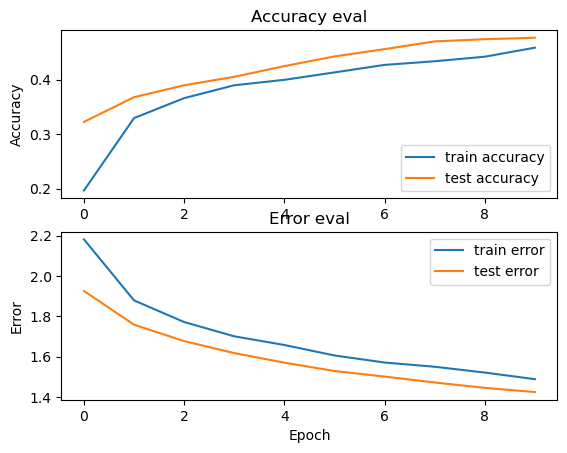

117/117 - 7s - loss: 1.4147 - accuracy: 0.4808 - 7s/epoch - 61ms/step

Test accuracy: 0.48076921701431274


2023-10-18 22:48:29.553118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 22:48:29.554196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 22:48:29.554900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
Target: 1, Predicted label: [3]


In [7]:
# Define the function to build the GRU model
def build_gru_model(input_shape):
    gru_model = keras.Sequential()

    gru_model.add(keras.layers.GRU(32, return_sequences=True, input_shape=input_shape))
    gru_model.add(keras.layers.BatchNormalization())

    gru_model.add(keras.layers.GRU(32, return_sequences=True))
    gru_model.add(keras.layers.BatchNormalization())

    gru_model.add(keras.layers.GRU(32))
    gru_model.add(keras.layers.BatchNormalization())

    gru_model.add(keras.layers.Dense(64, activation='relu'))
    gru_model.add(keras.layers.Dropout(0.2))

    gru_model.add(keras.layers.Dense(10, activation='softmax'))

    return gru_model


    
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2]) 
    
gru_model = build_gru_model(input_shape)

optimiser = keras.optimizers.RMSprop(learning_rate=0.0001)
gru_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

gru_model.summary()
    
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = gru_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=10, callbacks=[early_stopping])
plot_history(history)

test_loss, test_acc = gru_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
    
X_to_predict = X_test[100]
y_to_predict = y_test[100]

predict(gru_model, X_to_predict, y_to_predict)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 87, 32)            1280      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 44, 32)           0         
 )                                                               
                                                                 
 batch_normalization_6 (Batc  (None, 44, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_1 (Conv1D)           (None, 44, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 22, 32)           0         
 1D)                                                             
                                                      

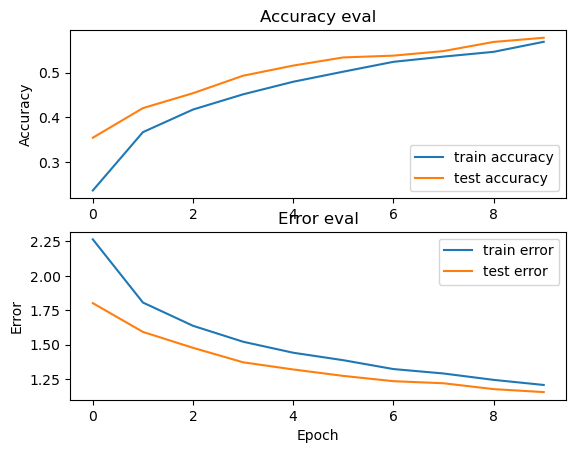

117/117 - 0s - loss: 1.1467 - accuracy: 0.5780 - 382ms/epoch - 3ms/step

Test accuracy: 0.5779914259910583
1/1 [==============================] - 0s 88ms/step
Target: 8, Predicted label: [8]


In [8]:
def tcn_build_model(input_shape):
    tcn_model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='causal'),
        layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='causal'),
        layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.Conv1D(32, kernel_size=2, activation='relu', padding='causal'),
        layers.MaxPooling1D(pool_size=2, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    return tcn_model



X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2]) 
num_classes = len(np.unique(y_train))

tcn_model = tcn_build_model(input_shape)

optimiser = keras.optimizers.RMSprop(learning_rate=0.0001)
tcn_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

tcn_model.summary()
    
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = tcn_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=10, callbacks=[early_stopping])
plot_history(history)

test_loss, test_acc = tcn_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
    
X_to_predict = X_test[100]
y_to_predict = y_test[100]

predict(tcn_model, X_to_predict, y_to_predict)

2023-10-18 22:49:48.963766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 22:49:48.964925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 22:49:48.965644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 87, 32)            5888      
                                                                 
 batch_normalization_9 (Batc  (None, 87, 32)           128       
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 87, 32)            8320      
                                                                 
 batch_normalization_10 (Bat  (None, 87, 32)           128       
 chNormalization)                                                
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 batch_normalization_11 (Bat  (None, 32)              

2023-10-18 22:49:49.238826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 22:49:49.239783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 22:49:49.240462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

281/281 [==============================] - ETA: 0s - loss: 2.3352 - accuracy: 0.1687

2023-10-18 22:50:37.451974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 22:50:37.453148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 22:50:37.453948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

281/281 [==============================] - 52s 172ms/step - loss: 2.3352 - accuracy: 0.1687 - val_loss: 2.0685 - val_accuracy: 0.2684
Epoch 2/10
281/281 [==============================] - 46s 165ms/step - loss: 2.0220 - accuracy: 0.2726 - val_loss: 1.8783 - val_accuracy: 0.3329
Epoch 3/10
281/281 [==============================] - 41s 145ms/step - loss: 1.8746 - accuracy: 0.3301 - val_loss: 1.7641 - val_accuracy: 0.3707
Epoch 4/10
281/281 [==============================] - 42s 149ms/step - loss: 1.7907 - accuracy: 0.3675 - val_loss: 1.6870 - val_accuracy: 0.3903
Epoch 5/10
281/281 [==============================] - 52s 184ms/step - loss: 1.7228 - accuracy: 0.3879 - val_loss: 1.6270 - val_accuracy: 0.4010
Epoch 6/10
281/281 [==============================] - 50s 177ms/step - loss: 1.6590 - accuracy: 0.4139 - val_loss: 1.5803 - val_accuracy: 0.4237
Epoch 7/10
281/281 [==============================] - 52s 185ms/step - loss: 1.6138 - accuracy: 0.4242 - val_loss: 1.5455 - val_accuracy: 0.4

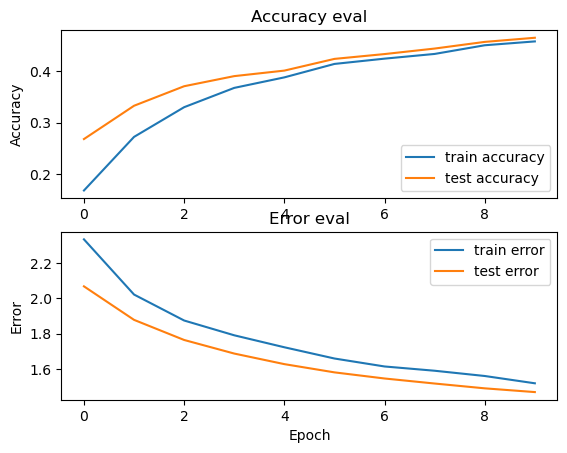

117/117 - 6s - loss: 1.4716 - accuracy: 0.4621 - 6s/epoch - 55ms/step

Test accuracy: 0.4620726406574249


2023-10-18 22:58:03.601984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 22:58:03.603281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 22:58:03.604116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 691ms/step
Target: 8, Predicted label: [0]


In [9]:
def build_lstm_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(32, return_sequences=True),
        layers.BatchNormalization(),
        
        layers.LSTM(32, return_sequences=True),
        layers.BatchNormalization(),
        
        layers.LSTM(32),
        layers.BatchNormalization(),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


  
input_shape = (X_train.shape[1], X_train.shape[2])  # Adapt based on your input data
num_classes = len(np.unique(y_train))
    
lstm_model = build_lstm_model(input_shape, num_classes)

optimiser = keras.optimizers.RMSprop(learning_rate=0.0001)
lstm_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lstm_model.summary()
    
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=10, callbacks=[early_stopping])
plot_history(history)

test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

X_to_predict = X_test[100]
y_to_predict = y_test[100]
predict(lstm_model, X_to_predict, y_to_predict)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 85, 11, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization_12 (Bat  (None, 43, 6, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 41, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 2, 32)        0         
 2D)                                                             
                                                      

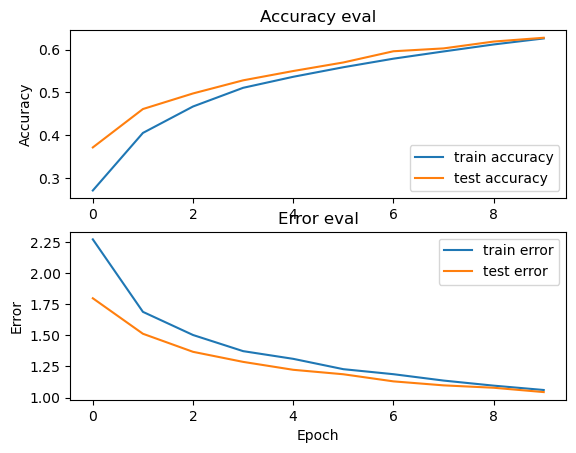

117/117 - 1s - loss: 1.0286 - accuracy: 0.6424 - 663ms/epoch - 6ms/step

Test accuracy: 0.6423611044883728
1/1 [==============================] - 0s 194ms/step
Target: 0, Predicted label: [3]


In [12]:
def cnn_build_model(input_shape):
    cnn_model = keras.Sequential()

    cnn_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    cnn_model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    cnn_model.add(keras.layers.BatchNormalization())

    cnn_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    cnn_model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    cnn_model.add(keras.layers.BatchNormalization())

    cnn_model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    cnn_model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    cnn_model.add(keras.layers.BatchNormalization())

    cnn_model.add(keras.layers.Flatten())
    cnn_model.add(keras.layers.Dense(64, activation='relu'))
    cnn_model.add(keras.layers.Dropout(0.2))

    cnn_model.add(keras.layers.Dense(10, activation='softmax'))

    return cnn_model


    
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
input_shape = (X_train.shape[1], X_train.shape[2], 1)
cnn_model = cnn_build_model(input_shape)

optimiser = keras.optimizers.RMSprop(learning_rate=0.0001)
cnn_model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()
    
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = cnn_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=10, callbacks=[early_stopping])
plot_history(history)

test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
X_to_predict = X_test[100]
y_to_predict = y_test[100]

predict(cnn_model, X_to_predict, y_to_predict)

In [13]:
models = [lstm_model, cnn_model, tcn_model, gru_model]
    
ensemble_predictions = []

for model in models:
    predictions = model.predict(X_validation)  
    ensemble_predictions.append(predictions)

ensemble_predictions = np.argmax(np.sum(ensemble_predictions, axis=0), axis=1)
ensemble_accuracy = accuracy_score(y_validation, ensemble_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)

71/71 [==============================] - 3s 47ms/step
Ensemble Accuracy: 0.6555407209612817
